# Portfolio Mnagement Thesis (Fall 2020)
## Leena Dighole

In [ ]:
'''
Project Title: Portfolio performance analysis using different ML/DL methods

Specifications:
1. Benchmark = SP500

2. Models used:
    1)LSTM RNN
    2)SVR
    
3.Optimizations:
    1)Active weight optimization with beta neutrality, full investment and tracking error constraints
    2) Max Sharpe Ratio
    
4. Models performance Analysis:
    1)RMSE-Root Mean Square Error
    2)MAE- Mean Absolute Error

    
Program Flexibility:
1. Flexibility of selection of no of stocks to construct portfolio
    Here you can select any no of stocks like top 'assets' stocks by Market capitalization(eg top 30 stocks)
2. Rolling window size selection
    User can select any no of window size 'window' to analyse differences in performances of model
3. Flexibility of training the model using today's stock prices
    The end date of downloading data is not hard coded for the reason that this code should be used at any time to 
    get up to  date results meaning the end date is set todays date and the data for our assets will be downloaded for todays date
    This gives the flexibility to train our model with the recent dataset to get better predictions
4. Flexibility of selecting Alpha model
    LSTM_RNN, SVR
5.Flexibility of user choosing daily returns or monthly returns for the predictions

    
Different portfolios are created using historical as well as model returns using 3 different weights
1. Equal weights : Benchmark Portfolio
2. Optimised using Active weights : Active Portfolio


Lets Surf the code!
    

'''

In [ ]:
#Note if these packages are not installed earlier then kindly install them one by one before running the code
#installing package for portfolio optimization
pip install PyPortfolioOpt

#installing packages for yahoo finance
pip install yfinance
pip install yahoo_fin
pip install requests_html

#Installing model support packages
pip install tensorflow
pip install keras
pip install scikit-learn
pip install xgboost

In [1]:
#Import Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from datetime import datetime
import yfinance as yf 
from yahoo_fin.stock_info import *

#Plotting size
plt.style.use('fivethirtyeight')

In [2]:
# Import Libraries for Model Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
#Libraries for Optimization
from pypfopt.efficient_frontier  import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import Bounds

In [4]:
#Import Libraries for Model space
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

#SVR modelspace
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


In [298]:
#Get the stock data for benchmark
class Data_InputSpace(object):
    '''
    Aim:The data collection of the Sp500 benchmark portfolio
    To Do:
    1.Download the data(daily closing prices) for all tickers in SP500 index from yahoo finance
    2.Calculate top 30 stocks by market Capitalization
    3.We will use these 30 stocks for expected return predictions
    Note: The data is downloaded from 2013-01-01 till todays date. This is done to be able to use all data upto todays date for predictions
    
    '''
    
    def __init__(self):  #initialization
        self.t = []                 #Storing stock tickers of SP500
        self.stockname =[]          #Storing stock n
        self.data_df = pd.DataFrame()    #storing adjusted closing day price of stocks
    
        
        
    def get_tickers(self): 
        '''
        Make the list of all tickers present in SP500 index.
        There are total 505 tickers in this index.
        '''
        self.t=tickers_sp500()
       # print('tickers',self.t)
        return self.t
    
    def get_data(self,stocknames): 
        '''
        Download the closing daily stock prices of the stocks in Sp500
        Remove the tickers from the list whose data is unavailable on yahoo finance
        Note: Start date is '2013-01-01' and end date will be todays date to be able to utilize all latest information for predictions
        '''
        self.stockname = stocknames
        #For calculating beta we need SP500 index historical data too
        self.stockname.append('^GSPC')
        
        #Download Daily closing prices
        self.stockStartDate = '2013-01-01'   #start date
        self.today = datetime.today().strftime('%Y-%m-%d')    #to get todays date
        self.data_df = yf.download(self.stockname,start= self.stockStartDate ,end = self.today)['Adj Close'][1:] 
        print('stock data frame\n',self.data_df)
        return self.data_df
    
    def top_30_stocks(self,stocknames,assets):
        '''
        Calculate top 30 stocks by market capitalization
        Use these stocks data for predicting expected returns of new portfolio
        '''
        self.stockname = stocknames
        self.mcaps = pd.DataFrame()   #storing market capitalization of stocks
        self.top_stock_no = int(assets)
      
        self.mcaps=data.get_quote_yahoo(self.stockname)['marketCap']   
        mcaps = self.mcaps
        print('Market Capitaization of stocks are:\n',self.mcaps)
        
        #Sort data to find top 30 stocks
        self.sorted_mcaps = sorted(mcaps.items(),key = lambda mcaps:mcaps[1],reverse =True)
        self.top_30_stocklist = self.sorted_mcaps[: self.top_stock_no]
        print('Top', assets,' stocklist using Market capitalisation is:\n',self.top_30_stocklist)
        return self.top_30_stocklist
                
                
        
    def data_processing(self,assets):
        '''
        1.collect stock names and corresponding tickers of the SP500
        2.Top 30 stocks with market capitalization are calculated for developing our portfolio
        3.Daily adjacent closing data of top 30 stocks is downloaded using yahoo finance
        '''
        stocknames = self.get_tickers()
        
        #Remove the stock names whose data is not present for given date periods
        self.fail =['BRK.B','BF.B','ZTS','VTRS','WY']
        for j in self.fail:
            stocknames.remove(j)
        
        #Calculate top 30 stocks by market capitalization and download their historical daily closing prices
        self.top_30_stocklist= self.top_30_stocks(stocknames,assets)
        self.top_30_stocknames = [i[0] for i in self.top_30_stocklist]
        print('top_30_stocknames \n',self.top_30_stocknames)
        self.historical_data = self.get_data(self.top_30_stocknames)
        
        return self.top_30_stocknames,self.historical_data

              
    
        

In [55]:
#Collect top 30 stocks and corresponding historical data
assets = input('Enter the no of top assets by Market capitalization to be used to construct portfolio:   ')
obj1 = Data_InputSpace()
top_30_stocks,historical_dataset = obj1.data_processing(int(assets))

#Top 30 stickers used for portfolio construction are:
# ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'FB', 'V', 'WMT', 'JNJ', 'JPM', 'MA', 'PG', 'NVDA', 'UNH', 'HD', 'DIS', 'PYPL', 'VZ', 'BAC', 'CMCSA', 'ADBE', 'KO', 'PFE', 'NFLX', 'NKE', 'INTC', 'T', 'MRK', 'CRM', 'PEP']

Enter the no of top assets by Market capitalization to be used to construct portfolio:   30
Market Capitaization of stocks are:
 A         36441538560
AAL       10035017728
AAP       10794971136
AAPL    2168309284864
ABBV     182401171456
            ...      
XYL       17893433344
YUM       32896897024
ZBH       31330068480
ZBRA      19861159936
ZION       6754014208
Name: marketCap, Length: 500, dtype: int64
Top 30  stocklist using Market capitalisation is:
 [('AAPL', 2168309284864), ('MSFT', 1649474273280), ('AMZN', 1605282168832), ('GOOGL', 1168614490112), ('GOOG', 1167466561536), ('FB', 775333019648), ('V', 465439162368), ('WMT', 412206333952), ('JNJ', 401936187392), ('JPM', 362583359488), ('PG', 342062202880), ('MA', 336302669824), ('NVDA', 327796097024), ('UNH', 318300979200), ('DIS', 317648699392), ('HD', 292167745536), ('PYPL', 274409783296), ('VZ', 249775112192), ('BAC', 249628917760), ('ADBE', 239072755712), ('NFLX', 234875912192), ('CMCSA', 233181184000), ('KO', 22776379801

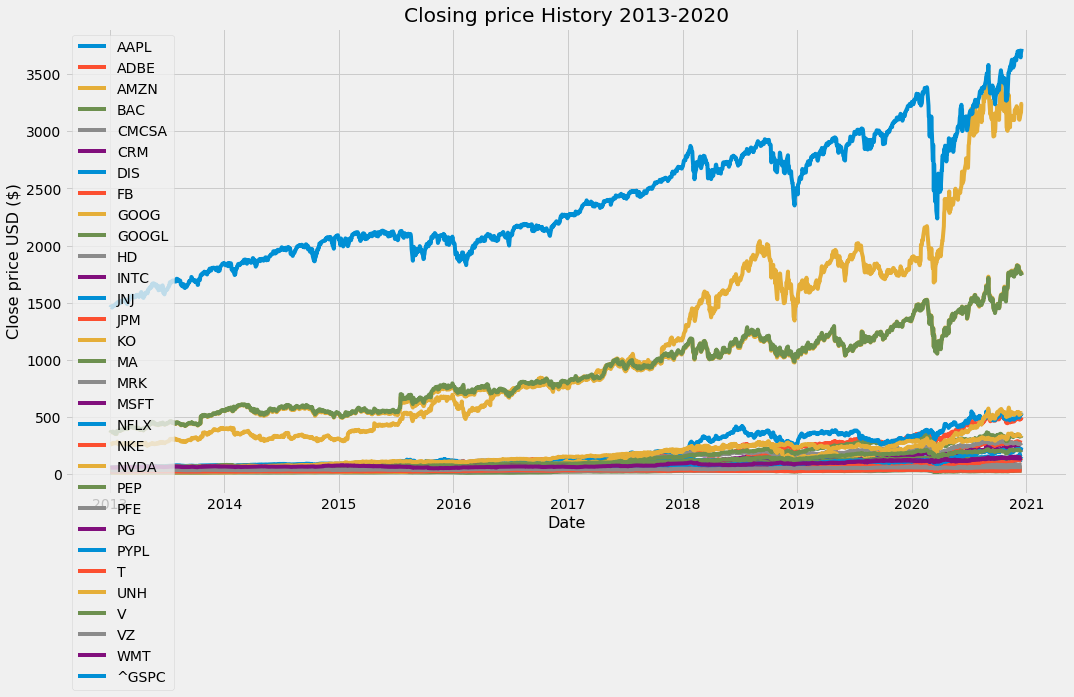

In [299]:
#Visualise the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing price History 2013-2020')
plt.plot(historical_dataset)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close price USD ($)', fontsize =16)
plt.legend(historical_dataset.columns)

In [300]:
#Calculate Monthly simple returns
'''
Motivation: The statistical properties of the returns over prices is useful to be used in predicting future returns
Formula: (Pt/Pt-1)-1
Simple returns are the percentage change in the price (Pt) at time t compared to previous price (Pt-1) at time t-1
The percentage change of prices is also refered as normalizing data to be able to measure all variables in a comparable metrics
'''
user = int(input('Enter the user preference for returns\n 1. Daily returns\n 2. Monthly returns\n'))
if user== 1:
    simple_returns = historical_dataset.pct_change()
elif user== 2:
    simple_returns = historical_dataset.resample('M').ffill().pct_change()
print('The Simple returns of the top 30 stocks are:\n',simple_returns)

Enter the user preference for returns
 1. Daily returns
 2. Monthly returns
1
The Simple returns of the top 30 stocks are:
                 AAPL      ADBE      AMZN       BAC     CMCSA       CRM  \
Date                                                                     
2013-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2013-01-04 -0.027855  0.010066  0.002592  0.012542 -0.000525  0.005335   
2013-01-07 -0.005882 -0.004983  0.035925 -0.001651 -0.004465 -0.003714   
2013-01-08  0.002692  0.005272 -0.007748 -0.009099  0.006860  0.005859   
2013-01-09 -0.015629  0.013634 -0.000113 -0.045910  0.006813  0.010943   
...              ...       ...       ...       ...       ...       ...   
2020-12-11 -0.006735 -0.002013  0.004814 -0.018550  0.008914 -0.002243   
2020-12-14 -0.005147  0.022084  0.013012 -0.012251  0.001178 -0.005170   
2020-12-15  0.050090 -0.007771  0.002582  0.014883  0.010198 -0.005062   
2020-12-16 -0.000547  0.015042  0.023961  0.002793 -0.001553  

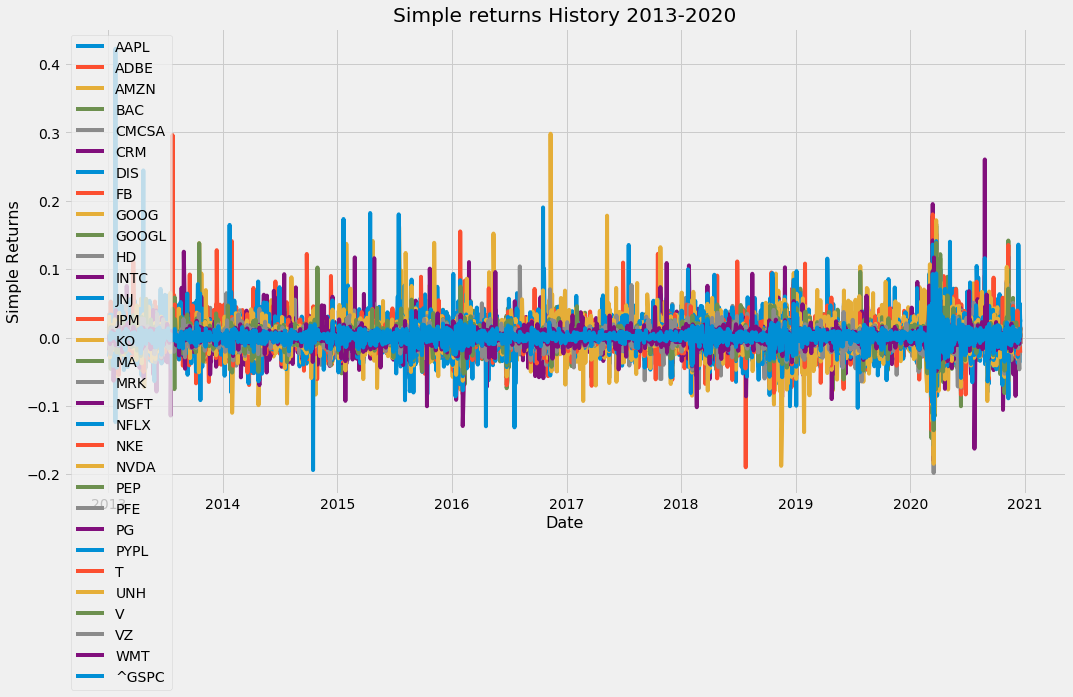

In [301]:
#Visualise the Simple returns history
plt.figure(figsize=(16,8))
plt.title('Simple returns History 2013-2020')
plt.plot(historical_dataset.pct_change())
plt.xlabel('Date', fontsize=16)
plt.ylabel('Simple Returns', fontsize =16)
plt.legend(historical_dataset.columns)

In [302]:
#As we normalized the data using simple returns,lets use log normal returns
'''
Motivation: We assume that prices of the stocks are distributed log normally.
The log normal returns log(1+ri) are assumed to be normally distributed, where ri is the simple return
Properties:
1. log(1+rt) = log(Pt)-log(pt-1)
2. If returns are very small r<<1, log(1+r) ~ r ....r<<<1
3. The simple additive property of logs can be used to avoid complex calculations for compound returns.
'''
log_returns = np.log(1+ simple_returns)
print('log returns are:\n',log_returns)


log returns are:
                 AAPL      ADBE      AMZN       BAC     CMCSA       CRM  \
Date                                                                     
2013-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2013-01-04 -0.028250  0.010016  0.002589  0.012464 -0.000525  0.005320   
2013-01-07 -0.005900 -0.004995  0.035295 -0.001653 -0.004475 -0.003721   
2013-01-08  0.002688  0.005258 -0.007778 -0.009140  0.006837  0.005842   
2013-01-09 -0.015753  0.013542 -0.000113 -0.046997  0.006790  0.010884   
...              ...       ...       ...       ...       ...       ...   
2020-12-11 -0.006758 -0.002015  0.004802 -0.018725  0.008875 -0.002245   
2020-12-14 -0.005160  0.021844  0.012928 -0.012326  0.001177 -0.005184   
2020-12-15  0.048876 -0.007801  0.002578  0.014773  0.010146 -0.005075   
2020-12-16 -0.000548  0.014930  0.023679  0.002789 -0.001554  0.015639   
2020-12-17  0.006939  0.011083 -0.001507  0.003823 -0.001362  0.010233   

                 DI

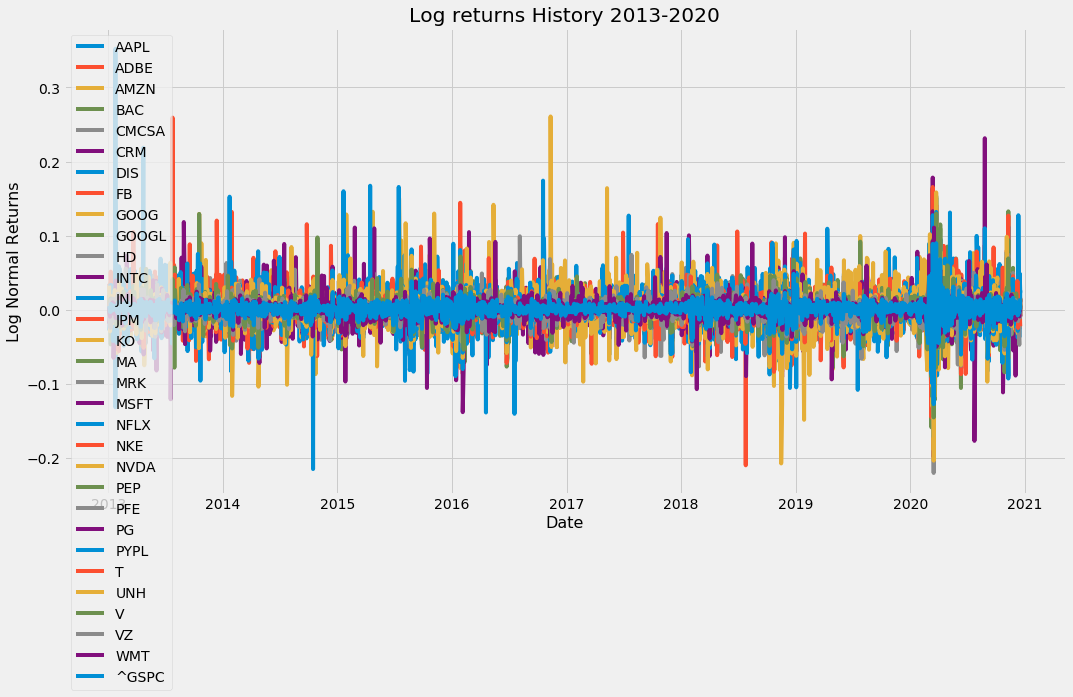

In [303]:
#Visualise the log returns history
plt.figure(figsize=(16,8))
plt.title('Log returns History 2013-2020')
plt.plot(log_returns)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Log Normal Returns', fontsize =16)
plt.legend(historical_dataset.columns)

In [ ]:
'''
Observations:
Notice that due to similar statistical features of simple returns and log normal returns,
we can use any one of them for our further data processing.
In this project the log returns are used for predicting future returns
Notice that the mean of returns are 0 and the prediction will allow us to get an intuition about whether
the price will go up or down the following day.
'''

In [305]:
#Drop NAN values from log returns while processing data
return_dataset=log_returns.fillna(0)
#print(return_dataset)
new_return_dataset = return_dataset.drop('^GSPC',axis=1)
print(new_return_dataset )


                AAPL      ADBE      AMZN       BAC     CMCSA       CRM  \
Date                                                                     
2013-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-01-04 -0.028250  0.010016  0.002589  0.012464 -0.000525  0.005320   
2013-01-07 -0.005900 -0.004995  0.035295 -0.001653 -0.004475 -0.003721   
2013-01-08  0.002688  0.005258 -0.007778 -0.009140  0.006837  0.005842   
2013-01-09 -0.015753  0.013542 -0.000113 -0.046997  0.006790  0.010884   
...              ...       ...       ...       ...       ...       ...   
2020-12-11 -0.006758 -0.002015  0.004802 -0.018725  0.008875 -0.002245   
2020-12-14 -0.005160  0.021844  0.012928 -0.012326  0.001177 -0.005184   
2020-12-15  0.048876 -0.007801  0.002578  0.014773  0.010146 -0.005075   
2020-12-16 -0.000548  0.014930  0.023679  0.002789 -0.001554  0.015639   
2020-12-17  0.006939  0.011083 -0.001507  0.003823 -0.001362  0.010233   

                 DIS        FB      G

In [306]:
#Training-Testing data set splitting
class Split_dataset(object):
    '''
    1.Convert closing date stock returns from dataframe into numpy arrays for splitting
    2.Scale the data between (0,1) using minmax scaling
    3.Split the data set into training (80%)and testing data(20%)
    4.Create x_train and y_train variables using rolling window size = 250
    '''
    
    def __init__(self,log_returns,window):  #Initialization
        self.h_dataset = log_returns
        self.window=int(window)   # dynamic rolling window size
        self.x_train =[]    #storing x_training data 
        self.y_train =[]    #storing y_training data 
        self.x_test =[]    #storing x_testing data 
       # self.y_test =[]     #storing y_testing data
        self.scaler = MinMaxScaler(feature_range=(0,1))
        
        
    def Minmax_scaler(self,log_returns,window):
        '''
        Motivation: The scaling of features is performed which includes robustness to very small deviations of features.
        The scaling enables us to preserve zero entries in sparse data.
        Feature scaling represents the significance of the features in th eprocess of selecting most significant features.
        Note we have 30 features and we are scaling them between [0,1] using minmax scaling
        Result:
        Note that our top 30 stocks selected as features are significant by seeing the scaled version of log returns of historical data. 
        '''
      
        #Convert dataframe to numpy array before splitting data
        self.dataset_values=log_returns.values
        #print('The array conversion of original dataset:\n',self.dataset_values)
            

        #Calculate no of rows to train the model
        self.training_dataset_len = math.ceil(len(self.dataset_values)* .8)   #80% training data
        print('The training dataset length is:',self.training_dataset_len)

        #Scale the data

        self.scaled_data = self.scaler.fit_transform(self.dataset_values)
        #print(self.scaled_data[:5])
        #print(self.scaled_data)
        
        #y =[x[0] for x in self.scaled_data]
        #print('y\n',y)
        return self.scaled_data
    
    def Create_training_data(self,log_returns,window):
        '''
        Lets look at our input and output space dimensions.
        Rolling window training dataset dimension will look like,
        x_train = [60*30]
        y_train =[1*30]
        where,
        60 is total no of rows in x_train input data rrepresenting data of past 60 days
        30 represents total no of features of data which are top 30 stocks in this project.
        '''
        #create the scaled training data set
        self.scaled_data = self.Minmax_scaler(log_returns,window)
        self.train_data = self.scaled_data[0:self.training_dataset_len , :]
        #print('self.train_data:\n',self.train_data)
        
        #Split the data into x_train and y_train datasets using 60 days rolling window
        for i in range(self.window, len(self.train_data)):
            self.x_train.append(self.train_data[i-self.window:i, :])   #scaled data of 60 days
            self.y_train.append(self.train_data[i, :])         #scaled data of 61st day
            
            #Lets take a look of our x_train and y_train dataset for first rolling window
            if i<= 10:
                print('**************************************************** \n')
                print('The first rolling window Training data will look like:\n')
                print('x_train \n',self.x_train)
                print('y_train \n',self.y_train)
              
        
        #Convert x_train and y_train dataset to numpy array for training modelspace
        self.x_train,self.y_train = np.array(self.x_train),np.array(self.y_train)
        print('x_train array:\n',self.x_train)
        print('y_train array:\n',self.y_train)
        
        return self.x_train,self.y_train
    
    def Create_testing_data(self,log_returns,window):
        '''
        Create the test data sets- x_test and y_test similar to training dataset 
        '''
        #Create the scaled test data
        self.test_data = self.scaled_data[self.training_dataset_len-self.window: , :]  
        print('Length of Test dataset is: ',len(self.dataset_values) -self.training_dataset_len )
        
        #Create the datasets x_test and y_test
        self.y_test = self.dataset_values[self.training_dataset_len:, :]
        for i in range (self.window, len(self.test_data)):
            self.x_test.append(self.train_data[i-self.window:i, :])   #scaled data of 60 days
            
            #Lets see the testing dataset for first rolling window
            if i<= 10:
                print('**************************************************** \n')
                print('The first rolling window test data will look like:\n')
                print('x_test \n',self.x_test)
                print('y_test \n',self.y_test[0])
               
                
        #Convert x_test and y_test dataset to numpy array for training modelspace
        self.x_test,self.y_test = np.array(self.x_test),np.array(self.y_test)
        print('x_test array:\n',self.x_test)
        print('y_test array:\n',self.y_test)
        
                
        return self.x_test,self.y_test

        
            
            
            
         
      
            
            
        


In [307]:
# Train-Test Splitting
window = input('Enter the rolling window size for LSTM model:')   #User input for rolling window size

obj2=Split_dataset(new_return_dataset,window)
x_train,y_train = obj2.Create_training_data(new_return_dataset,window)
x_test,y_test = obj2.Create_testing_data(new_return_dataset,window)

Enter the rolling window size for LSTM model:250
The training dataset length is: 1604
x_train array:
 [[[0.5489317  0.49440969 0.46848364 ... 0.52893036 0.48070956 0.49238042]
  [0.43632078 0.52545162 0.47889319 ... 0.55848767 0.51883072 0.50967166]
  [0.52541388 0.47892744 0.61041206 ... 0.55479403 0.54222282 0.44835521]
  ...
  [0.52236993 0.49701186 0.52042661 ... 0.55326768 0.50930858 0.51465629]
  [0.52190717 0.49076608 0.40524257 ... 0.52017411 0.47928163 0.49705877]
  [0.50908995 0.49649222 0.42062178 ... 0.54938415 0.47785506 0.50171806]]

 [[0.43632078 0.52545162 0.47889319 ... 0.55848767 0.51883072 0.50967166]
  [0.52541388 0.47892744 0.61041206 ... 0.55479403 0.54222282 0.44835521]
  [0.55964712 0.51070452 0.43720653 ... 0.56260333 0.30781534 0.50509826]
  ...
  [0.52190717 0.49076608 0.40524257 ... 0.52017411 0.47928163 0.49705877]
  [0.50908995 0.49649222 0.42062178 ... 0.54938415 0.47785506 0.50171806]
  [0.59538846 0.5115371  0.52351141 ... 0.55792644 0.47928151 0.495878

In [308]:
#Lets check the shape of x_train, y_train ,x_test, y_test
'''
LSTM modelspace requires 3-D data which are:
1. Samples
2.Time steps
3.Features
Note that our above x_train data is a 3-D LSTM compatible data
The time steps refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for
weight updates during training phase of model.
'''
x_shape = x_train.shape
print('The x_train dimensions are:\n',x_shape)

y_shape = y_train.shape
print('The y_train dimensions are:\n',y_shape)

x_testshape = x_test.shape
print('The x_test dimensions are:\n',x_testshape)

y_testshape = y_test.shape
print('The y_test dimensions are:\n',y_testshape)

scaler = MinMaxScaler(feature_range=(0,1))

The x_train dimensions are:
 (1354, 250, 30)
The y_train dimensions are:
 (1354, 30)
The x_test dimensions are:
 (401, 250, 30)
The y_test dimensions are:
 (401, 30)


In [309]:
#Model Space 1
#LSTM RNN model to predict future returns of the top 30 stocks
class LSTM_RNN_ModelSpace(object):
    
    def __init__(self,x_train_set,y_train_set,x_test_set,y_test_set,log_returns): #initialization
        self.x_train = x_train_set
        self.y_train = y_train_set
        self.x_test = x_test_set
        self.y_test = y_test_set
        #Create a sequential RNN model
        self.model = Sequential()
      
        

        
    def Create_LSTM_model(self,x_train_set,y_train_set,assets):
        '''
        Motivation: Create an LSTM RNN model to predict future returns
        Sequential models have plain stack of layers with one i/p and one o/p tensor
        
        Keywords:
        1.Batch = batch size of training data used for Stochastic Gradient descent optimization
        2.Epoch = no of times the model will be passed through the given training data set
        
        To Do: 
        A) LSTM RNN Model Construction:
        1)First  LSTM model Layer:
            *Number of nodes = 50
            *We want return sequences =True to be able to add next layer
            *Input shape consists of no of time steps and no of features
                Here no of time stpes = size of rolling window = 60
                and No of features = top 30 stocks = 30
        2)Second LSTM layer:
            *Number of nodes = 50
            *We want return sequences= False as we want to use 2 LSTM layer model in this project
        
        3)We will add certain dense layers after LSTM in our RNN model
            *Third layer will be a dense layer with 25 nodes
            *Forth layer will be one dense layer
                    
        '''
        
        #First LSTM Layer
        self.model.add(LSTM(50, return_sequences = True, input_shape = (self.x_train.shape[1], self.x_train.shape[2])))
        
        #Second LSTM layer
        self.model.add(LSTM(50, return_sequences = False))  #We are using 2 LSTM layers only
        
        #Add a dense layer with nodes =25
        self.model.add(Dense(25))
        
        #Add a dense layer with node = 1
        self.model.add(Dense(1))
        
        #Compile the model using Adam optimizer and MSE as a loss function
        self.model.compile(optimizer = 'adam',loss ='mean_squared_error')
        
        #Train the LSTM RNN model
        '''
        The no of epochs were selected by running the model with different epoch sizes.
        For epoch 1 , loss = 0.0089
        for epoch 5, loss = 0.0069
        for epoch 8, loss = 0.0069
        For epoch 10, loss = 0.0068
        
        Here we can observe that the loss value is not changing drastically from epoch 5 to 10 
        and we can say that the convergence may have occured and choose the epoch 10 for our further calculations.
        
        Case 1: batch_size =1 and epoch =10
        Entire dataset is passed in each epoch iteration
        Results: 
        Epoch 1/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0089
        Epoch 2/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0072
        Epoch 3/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0071 0s -
        Epoch 4/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0070
        Epoch 5/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 6/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 7/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 8/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        Epoch 9/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 10/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        
        case 2: batch_size = 3 and epoch =10
        The randomly choosen 1/3rd of the entire dataset is passed in each epoch iteration
        
        Epoch 1/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0082
        Epoch 2/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0069
        Epoch 3/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 4/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 5/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 6/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 7/10
        346/346 [==============================] - 16s 46ms/step - loss: 0.0070
        Epoch 8/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        Epoch 9/10
        346/346 [==============================] - 16s 48ms/step - loss: 0.0068
        Epoch 10/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        
        Note that above 2 examples are here to show the differences between selecting different batch size and epoch size
        
        case 3: batch size =10, epoch = 10 (To manage tradeoff between accuracy and computational time)
        
        With observations made from above 2 cases, we will use batch_size = 10 and epoch = 5 to train our model
        '''
        #Train the model using epoch 10
        #We used batch size=1 as we want to pass the entire dataset to the model while training it
        self.model.fit(self.x_train,self.y_train,validation_data=(self.x_test,self.y_test) ,batch_size =10 ,epochs =5)
        
        #Print model summary
        print(self.model.summary())
        return self.model
        
        
    def LSTM_Predictions(self,x_test_set,y_test_set):
       
        '''
        Motivation: Perform predictions of returns using testing dataset
        To do:
        y_test is the log normal return values dataset
        x_test is the scaled values dataset
        Thus we need to take inverse scalar form of the predictions performed by scaled data to get predicted log returns
        For predictions,
        x_test(scaled version) => y_predicted(scaled version) => y_predicted(log returns) using inverse scaling transform
        '''
        #Predictions of scaled data
        #self.model=model
        #self.x_train = x_test_set
        #self.x_train = x_test_set
        
        self.train_predictions = self.model.predict(self.x_train)
        self.test_predictions = self.model.predict(self.x_test)
        #print(' self.train_predictions',  self.train_predictions)
       # print('***********************************************')
        #print(' self.test_predictions',  self.test_predictions)
        
       
        return self.test_predictions,self.test_predictions
    
        
    
    

           
            
    

In [310]:
#Model Space 2
#SVR model to predict future returns of the top 30 stocks
class SVR_ModelSpace(object):
    
    def __init__(self,x_train_set,y_train_set,x_test_set,y_test_set,log_returns): #initialization
        self.x_train = x_train_set
        self.y_train = y_train_set
        self.x_test = x_test_set
        self.y_test = y_test_set
                
    def Create_SVR_model(self):
        '''
        Motivation: Create an SVR model to predict future returns
        
        Keywords:
        1.rbf = Radial Basis Function
        This kernel function is used to create SVR
        Formula: exp(-gamma*||x-x'||^2)  where gamma >0
        
        To Do: 
        A) SVR Model Construction:
            1.kernel fn = rbf
            2.Regularization parameter = C
            3. Gamma value
            
        Note that high C value aims at classifying all training examples correctly
        and gamma value represents how much influence a single training example has on the model parameters.
        link: 
        https://scikit-learn.org/stable/modules/svm.html#kernel-functions
                    
        '''
        #create SVR model
        self.svr_model = SVR(kernel = 'rbf', C= 1e3, gamma = 0.1)
        
        #Train Model
        self.svr_model.fit(self.x_train,self.y_train)
        
        #Testing model
        '''
        Score value returns the coefficient of the determination R^2 of the predictions
        The possible best score =1
        '''
        self.svr_confidence = self.svr_model.score(self.x_test,self.y_test)
        #print('The SVM confidence is:',self.svr_confidence)
       
        #Predictions using SVR
        self.svr_test_predictions= self.svr_model.predict(self.x_test)
        self.svr_train_predictions= self.svr_model.predict(self.x_train)
        
        #print('self.svr_test_predictions',self.svr_test_predictions)
       # print('***************************************************')
        #print('self.svr_train_predictions',self.svr_train_predictions)
        
        return self.svr_train_predictions,self.svr_test_predictions
        
        
      


In [311]:
'''
Motivation: Predicting Expected log returns of the assets

Selection:
1. LSTM RNN  model
2. SVR Model

'''
class Model_selection (object):
    
    def Choose_model(self,x_train,y_train,x_test,y_test,log_returns,model):
        self.train_predicted_set =pd.DataFrame()
        self.test_predicted_set =pd.DataFrame()

        for i in range(int(assets)):
            #Training the LSTM model for each stock
            self.x_train = x_train[:,:,i]
            self.y_train = y_train[:,i]
            self.x_test = x_test[:,:,i]
            self.y_test = y_test[:,i]

            #Model Selection
            if model ==1:
                #Reshape the input data of LSTM
                self.x_train=np.reshape(self.x_train, (self.x_train.shape[0],self.x_train.shape[1],1))
                self.x_test=np.reshape(self.x_test, (self.x_test.shape[0],self.x_test.shape[1],1))
                
                #Create LSTM model and train it
                obj3 = LSTM_RNN_ModelSpace(self.x_train,self.y_train,self.x_test,self.y_test,log_returns)
                LSTM_model =obj3.Create_LSTM_model(self.x_train,self.y_train,int(assets))

                #Predictions using trained LSTM model
                train_predictions, test_predictions =obj3.LSTM_Predictions(self.x_test,self.y_test)
            
            elif model ==2:
                #Create SVR model and train it
                obj4 = SVR_ModelSpace(self.x_train,self.y_train,self.x_test,self.y_test,log_returns)
                train_predictions, test_predictions =obj4.Create_SVR_model()
                

            #Collect the expected returns of all assets
            self.train_predicted_set[top_30_stocks[i]] =  train_predictions.flatten()
            self.test_predicted_set[top_30_stocks[i]] =  test_predictions.flatten()
                
            print('***********************************************')
            print('The asset ',i+1,' prediction is completed....\n')
           
        scaler = MinMaxScaler(feature_range=(0,1))
        self.dataset_values=log_returns.values
        self.scaled_data = scaler.fit_transform(self.dataset_values)
        #print(self.test_predictions.shape)
        
        #Inverse the Scaled the data to get log normal data
        self.final_train_predictions = self.train_predicted_set.values
        self.final_test_predictions = self.test_predicted_set.values
        
        self.final_train_predictions =scaler.inverse_transform(self.final_train_predictions)
        #print('The predicted values are:\n',self.train_predictions)
        
        #print('**************************************')
        self.final_test_predictions =scaler.inverse_transform(self.final_test_predictions)
        #print('The predicted values are:\n',self.test_predictions)
        

        #print('train_predicted_set',train_predicted_set)
        #print('test_predicted_set',test_predicted_set)

        print('train_predicted_set',self.final_train_predictions)
        print('test_predicted_set',self.final_test_predictions)

        return self.final_train_predictions,self.final_test_predictions
    
   

In [314]:
#Choose Alpha model
model = int(input('Enter the Alpha model used for predictions:\n 1 for LSTM\n 2 for SVR: \n'))
obj5 =Model_selection()

#Choose models
if model == 1:  #LSTM Model
    final_train_predictions_1,final_test_predictions_1 = obj5.Choose_model(x_train,y_train,x_test,y_test,new_return_dataset,model)
elif model ==2: #SVR Model
    final_train_predictions_2,final_test_predictions_2 = obj5.Choose_model(x_train,y_train,x_test,y_test,new_return_dataset,model)

Enter the Alpha model used for predictions:
 1 for LSTM
 2 for SVR: 
1
Epoch 1/5
136/136 [==============================] - 30s 221ms/step - loss: 0.0112 - val_loss: 0.3052
Epoch 2/5
136/136 [==============================] - 27s 201ms/step - loss: 0.0042 - val_loss: 0.3023
Epoch 3/5
136/136 [==============================] - 29s 214ms/step - loss: 0.0043 - val_loss: 0.3160
Epoch 4/5
136/136 [==============================] - 27s 197ms/step - loss: 0.0041 - val_loss: 0.3305
Epoch 5/5
136/136 [==============================] - 31s 231ms/step - loss: 0.0042 - val_loss: 0.2941
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_191 (LSTM)              (None, 250, 50)           10400     
_________________________________________________________________
lstm_192 (LSTM)              (None, 50)                20200     
_________________________________________________________________


***********************************************
The asset  5  prediction is completed....

Epoch 1/5
136/136 [==============================] - 19s 140ms/step - loss: 0.0087 - val_loss: 0.1789
Epoch 2/5
136/136 [==============================] - 19s 137ms/step - loss: 0.0024 - val_loss: 0.1954
Epoch 3/5
136/136 [==============================] - 19s 142ms/step - loss: 0.0025 - val_loss: 0.1852
Epoch 4/5
136/136 [==============================] - 19s 140ms/step - loss: 0.0024 - val_loss: 0.1826
Epoch 5/5
136/136 [==============================] - 22s 159ms/step - loss: 0.0024 - val_loss: 0.1843
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_201 (LSTM)              (None, 250, 50)           10400     
_________________________________________________________________
lstm_202 (LSTM)              (None, 50)                20200     
_____________________________________________

***********************************************
The asset  11  prediction is completed....

Epoch 1/5
136/136 [==============================] - 20s 149ms/step - loss: 0.0082 - val_loss: 0.2616
Epoch 2/5
136/136 [==============================] - 19s 141ms/step - loss: 0.0019 - val_loss: 0.2852
Epoch 3/5
136/136 [==============================] - 20s 145ms/step - loss: 0.0019 - val_loss: 0.2700
Epoch 4/5
136/136 [==============================] - 19s 136ms/step - loss: 0.0019 - val_loss: 0.2881
Epoch 5/5
136/136 [==============================] - 18s 135ms/step - loss: 0.0019 - val_loss: 0.2912
Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_213 (LSTM)              (None, 250, 50)           10400     
_________________________________________________________________
lstm_214 (LSTM)              (None, 50)                20200     
____________________________________________

***********************************************
The asset  17  prediction is completed....

Epoch 1/5
136/136 [==============================] - 20s 145ms/step - loss: 0.0086 - val_loss: 0.3282
Epoch 2/5
136/136 [==============================] - 20s 150ms/step - loss: 0.0029 - val_loss: 0.2842
Epoch 3/5
136/136 [==============================] - 19s 136ms/step - loss: 0.0030 - val_loss: 0.2910
Epoch 4/5
136/136 [==============================] - 19s 137ms/step - loss: 0.0027 - val_loss: 0.3000
Epoch 5/5
136/136 [==============================] - 19s 137ms/step - loss: 0.0030 - val_loss: 0.2946
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_225 (LSTM)              (None, 250, 50)           10400     
_________________________________________________________________
lstm_226 (LSTM)              (None, 50)                20200     
____________________________________________

***********************************************
The asset  23  prediction is completed....

Epoch 1/5
136/136 [==============================] - 21s 157ms/step - loss: 0.0053 - val_loss: 0.2012
Epoch 2/5
136/136 [==============================] - 19s 143ms/step - loss: 0.0024 - val_loss: 0.1917
Epoch 3/5
136/136 [==============================] - 19s 137ms/step - loss: 0.0023 - val_loss: 0.2104
Epoch 4/5
136/136 [==============================] - 19s 142ms/step - loss: 0.0023 - val_loss: 0.2175
Epoch 5/5
136/136 [==============================] - 19s 140ms/step - loss: 0.0022 - val_loss: 0.1944
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_237 (LSTM)              (None, 250, 50)           10400     
_________________________________________________________________
lstm_238 (LSTM)              (None, 50)                20200     
____________________________________________

***********************************************
The asset  29  prediction is completed....

Epoch 1/5
136/136 [==============================] - 31s 225ms/step - loss: 0.0069 - val_loss: 0.2653
Epoch 2/5
136/136 [==============================] - 29s 215ms/step - loss: 0.0033 - val_loss: 0.2475
Epoch 3/5
136/136 [==============================] - 30s 217ms/step - loss: 0.0034 - val_loss: 0.2302
Epoch 4/5
136/136 [==============================] - 28s 203ms/step - loss: 0.0035 - val_loss: 0.2328
Epoch 5/5
136/136 [==============================] - 29s 215ms/step - loss: 0.0034 - val_loss: 0.2359
Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_249 (LSTM)              (None, 250, 50)           10400     
_________________________________________________________________
lstm_250 (LSTM)              (None, 50)                20200     
____________________________________________

In [315]:
#Estimate Errors for LSTM models

#Test RMSE
print('For LSTM RNN Alpha model:\n')
Test_RMSE_1 = math.sqrt(mean_squared_error(y_test,final_test_predictions_1))
print('Testing RMSE is:',Test_RMSE_1)

#Mean Absolute Test Error
Test_MAE_1 = mean_absolute_error(y_test,final_test_predictions_1)
print('Testing MAE is:',Test_MAE_1)



For LSTM RNN Alpha model:

Testing RMSE is: 0.023804663509223785
Testing MAE is: 0.015521840622308632


In [313]:
#Estimate Errors for SVR models

#Test RMSE
print('For SVR Alpha model:\n')
Test_RMSE_2 = math.sqrt(mean_squared_error(y_test,final_test_predictions_2))
print('Testing RMSE is:',Test_RMSE_2)

#Mean Absolute Test Error
Test_MAE_2 = mean_absolute_error(y_test,final_test_predictions_2)
print('Testing MAE is:',Test_MAE_2)


For SVR Alpha model:

Testing RMSE is: 0.025875889352052164
Testing MAE is: 0.017531853939218345


In [ ]:
'''
Motivation: Performance Analysis of models
Case 1: Daily returns
Performance Table:(Assets  = 30 stocks and rolling window = 252(approx. 1 year previous data))
             LSTM RNN model              SVR Model
    RMSE     0.02384906884938217         0.026664577902939243
    MAE      0.015503307414748362        0.0182782774388283

Case 2: Monthly returns
Performance Table:(Assets  = 30 stocks and rolling window = 36(approx. 3 years previous data))
             LSTM RNN model              SVR Model
    RMSE     0.07958155114468012         0.08581207681983924
    MAE      0.061042180231722684        0.06553587847999746
    
Thus we can say that LSTM RNN model gives more accurate predictions than SVR which is an expected result inline 
with our Literature review!
More the no of training dataset, less will be the RMSE and MAE error.
We compared the Daily returns and Monthly returns errors and can be observed that the model prediction accuracy increases
as the no of training dataset increases.

'''

In [285]:
#Lets calculate beta value
'''
For risk free CAPM model,
beta = cov(Ra,Rm)/var(Rm)
where,
    Ra= Asset return
    Rm = Market (Sp500 here) return
    
'''
if user == 1: #daily returns
    cov = return_dataset.cov()*252
elif user ==2: #monthly returns
     cov = return_dataset.cov()*12
cov

       

,AAPL,ADBE,AMZN,BAC,CMCSA,CRM,DIS,FB,GOOG,GOOGL,...,PEP,PFE,PG,PYPL,T,UNH,V,VZ,WMT,^GSPC
AAPL,1.550807,0.618464,0.695791,0.536397,0.385537,0.738103,0.470377,0.665348,0.461963,0.469098,...,0.240951,0.209382,0.286615,0.561368,0.207483,0.260143,0.484148,0.157425,0.239602,0.489551
ADBE,0.618464,0.897276,0.747105,0.466851,0.307417,0.753282,0.463656,0.608530,0.416416,0.420526,...,0.184840,0.182101,0.090899,0.477442,0.083434,0.256291,0.519120,0.052308,0.118332,0.384799
AMZN,0.695791,0.747105,1.618440,0.549833,0.328828,0.795145,0.435748,0.678851,0.715538,0.719173,...,0.264113,0.422565,0.134157,0.581776,0.121210,0.341253,0.580785,0.117785,0.158025,0.472019
BAC,0.536397,0.466851,0.549833,1.646987,0.593006,0.665820,0.765081,0.556960,0.537053,0.531002,...,0.198747,0.442846,0.180500,0.393343,0.308355,0.461603,0.484049,0.071028,0.118297,0.579003
CMCSA,0.385537,0.307417,0.328828,0.593006,0.880054,0.403344,0.597181,0.427146,0.363184,0.371139,...,0.358291,0.323178,0.303396,0.381199,0.374674,0.229835,0.358519,0.342257,0.286446,0.392866
CRM,0.738103,0.753282,0.795145,0.665820,0.403344,1.531413,0.510371,0.832575,0.586685,0.580539,...,0.167881,0.239316,0.109223,0.483173,0.080434,0.241594,0.633487,0.019181,0.007695,0.453297
DIS,0.470377,0.463656,0.435748,0.765081,0.597181,0.510371,1.131720,0.522554,0.423329,0.425239,...,0.310685,0.400290,0.206623,0.425769,0.337080,0.330117,0.499757,0.230257,0.166272,0.479849
FB,0.665348,0.608530,0.678851,0.556960,0.427146,0.832575,0.522554,1.867375,0.571177,0.581547,...,0.120430,0.207214,0.135609,0.559735,0.130030,0.305306,0.419803,0.058785,0.108842,0.401246
GOOG,0.461963,0.416416,0.715538,0.537053,0.363184,0.586685,0.423329,0.571177,0.885068,0.889040,...,0.227617,0.221319,0.148316,0.419659,0.164323,0.150024,0.461481,0.174774,0.083933,0.368643
GOOGL,0.469098,0.420526,0.719173,0.531002,0.371139,0.580539,0.425239,0.581547,0.889040,0.898291,...,0.232597,0.217759,0.151321,0.427801,0.163736,0.146340,0.461190,0.173034,0.087037,0.370071


In [286]:
#covariance matrix
cov_with_market = cov[cov.columns[len(cov)-1]]
cov_with_market

AAPL     0.489551
ADBE     0.384799
AMZN     0.472019
BAC      0.579003
CMCSA    0.392866
CRM      0.453297
DIS      0.479849
FB       0.401246
GOOG     0.368643
GOOGL    0.370071
HD       0.390750
INTC     0.297753
JNJ      0.289222
JPM      0.477355
KO       0.252737
MA       0.462049
MRK      0.189457
MSFT     0.331602
NFLX     0.318468
NKE      0.303508
NVDA     0.516213
PEP      0.234647
PFE      0.288793
PG       0.182313
PYPL     0.379666
T        0.259495
UNH      0.265187
V        0.372904
VZ       0.182924
WMT      0.157333
^GSPC    0.385605
Name: ^GSPC, dtype: float64

In [287]:
#Market variance
#Note that the calculated value matches with the value of cov(Rm,Rm) = Var(Rm)
if user == 1:
    market_var = return_dataset['^GSPC'].var()*252
elif user==2:
    market_var = return_dataset['^GSPC'].var()*12
market_var

0.3856046844385508

In [288]:
#beta value calculation
#beta > 1 indicates that the stock swings higher than market and are more risky assets
beta_val_list = cov_with_market/market_var
beta_val_list = beta_val_list.drop('^GSPC',axis=0) 
beta_val_list

AAPL     1.269566
ADBE     0.997910
AMZN     1.224101
BAC      1.501546
CMCSA    1.018831
CRM      1.175547
DIS      1.244406
FB       1.040564
GOOG     0.956013
GOOGL    0.959716
HD       1.013343
INTC     0.772171
JNJ      0.750047
JPM      1.237940
KO       0.655431
MA       1.198245
MRK      0.491325
MSFT     0.859954
NFLX     0.825892
NKE      0.787095
NVDA     1.338710
PEP      0.608517
PFE      0.748936
PG       0.472797
PYPL     0.984598
T        0.672957
UNH      0.687716
V        0.967063
VZ       0.474381
WMT      0.408015
Name: ^GSPC, dtype: float64

In [263]:
#Portfolio
'''
Lets construct a portfolio on monthly basis with no of assets
Breadth = BR = sqrt(12*no of assets)
IC = IR/sqrt(BR)
TE = active risk = sqrt(Active return var)
we have beta value.
Lets use predicted monthly returns to optimise portfolio active return
Lets construct portfolio starting from the first monthly predicted data from alpha model 
'''
if model ==1:  #LSTM RNN
    alpha_val_list = final_test_predictions_1
elif model==2:  #SVR
    alpha_val_list = final_test_predictions_2


In [156]:
#Portfolio Optimization using active returns
'''
Motivation: Maximise risk adjusted active return
Formula: max(active returns - active risk penalty)
        max(wA'*alpha-(lambda/2*wA'*sigma*wA)
Lets asssume,
    wA =wP-wB
    sigma = cov(alpha)
    lambda = risk aversion parameter
    
Constraits:
1. Beta neutrality wA'*beta = 0
2. Full investment wA'1 = 0
3. Tracking Error = sqrt(wA'*Sigma*wA) <= 0.03

Note that our benchmark portfolio is the equally weighted assets portfolio
wB = [1/30,1/30....,1/30]... for assets = 30

Benchmark return (Rb) = alpha*wB
Portfolio return(Rp) = alpha*wP
Active return(Ra) = Rp-Rb

We will construct our portfolio using above constraints and maximising risk adjusted active return using predicted alpha returns
Once we have our active weights, we can calculate below parameters.
Performance analysis:
1. IR = active return/ active risk
        = Ra/TE
2. TE = sqrt(wA'*Sigma*wA)
3. IC = IR/sqrt(BR)
4. Portfolio variance (var(P))= wP'*Sigma*wP
5. Bechmark variance(var(B)) = wB'*Sigma*wB
6. Sharpe ratio = Rp/sqrt(var(P))
'''
class Portfolio_Optimization(object):
    
    def __init__(self,alpha_val_list,beta_val_list,assets,t):  #Initialization
        self.alpha = alpha_val_list   #alpha value list
        self.beta = beta_val_list     #beta value list
        self.sig = t   #cov of alpha returns
        self.W0 = [1/int(assets) for i in range(int(assets))]   #equally weighted
        self.bounds = Bounds([0]*len(self.W0),[1]*len(self.W0))  #0<= wp<= 1 bounds
    
    def objective_fn(self, W,alpha_val_list):
        #Max(W*alpha)
        #Max active return- active risk penalty
        for l in range(100):
            self.obj_fn = -sum([i*j for i,j in zip(W,self.alpha)])-l *[np.sqrt(np.transpose(np.array(W-self.W0)).dot(self.sig).dot(np.array(W-self.W0)))]
        return self.obj_fn
    
    def weight_cond(self,W):
        #wA'1=0
        #All weights adds upto 1
        self.constraint3= sum(W)-1
        return self.constraint3
    
    def beta_neutral_cond(self,W):
        #wA*beta_list =0
        #constraint 1
        self.WA = W-self.W0  #Active weights
        self.constraint1 = sum([i*j for i,j in zip(self.WA,self.alpha)]) 
        return self.constraint1
    
    def Tracking_error_cond(self,W):
        #3% TE constraint
        #Tracking Error = sqrt(wA'*Sigma*wA) <= 0.03
        self.constraint2 = (0.03)-[np.sqrt(np.transpose(np.array(W-self.W0)).dot(self.sig).dot(np.array(W-self.W0)))]
        return self.constraint2
    
    def optimize(self):
        #TE constraint (Note this is inequality constraint)
        self.TE_constraint = {'type':'ineq','fun':lambda W: self.Tracking_error_cond}
        
        #Equality constraints
        self.Beta_constraint = {'type':'eq','fun': self.beta_neutral_cond}
        self.Weight_constraint = {'type':'eq','fun': self.weight_cond}
        
        self.solve = minimize(self.objective_fn,self.W0,(self.alpha), method = 'SLSQP',
                             constraints = [self.Beta_constraint,self.Weight_constraint,self.TE_constraint],
                             options = {'ftol':1e-9,'disp':True}, 
                             bounds = self.bounds)
        self.w = self.solve.x
        print(self.solve.x)
        return self.w
    


In [245]:
t = pd.DataFrame(alpha_val_list).cov()*252
t

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.007954,0.001673,-0.001953,0.012208,0.002906,-0.000298,0.003589,-0.000810,-0.001439,-0.002723,...,0.008492,0.000035,0.000211,0.000010,0.003864,-0.002074,0.002553,0.000557,-0.003046,0.001830
1,0.001673,0.000562,-0.000186,0.001606,0.000568,0.000240,0.000830,-0.000088,-0.000087,-0.000431,...,0.000580,0.000084,0.000043,-0.000080,0.001050,-0.000600,0.000398,0.000332,-0.000725,0.000389
2,-0.001953,-0.000186,0.001548,-0.004139,-0.001043,0.000741,-0.000408,0.000317,0.000677,0.000499,...,-0.004625,0.000045,-0.000022,-0.000376,-0.001447,-0.000192,-0.001217,0.000458,0.000310,-0.001397
3,0.012208,0.001606,-0.004139,0.024304,0.004921,-0.001934,0.004700,-0.001651,-0.003527,-0.005006,...,0.020835,-0.000198,0.000699,0.000454,0.004992,-0.002168,0.005018,-0.000375,-0.004225,0.003351
4,0.002906,0.000568,-0.001043,0.004921,0.001420,-0.000171,0.000998,-0.000334,-0.000788,-0.001112,...,0.004661,0.000083,0.000382,0.000313,0.001669,-0.000184,0.001391,-0.000060,-0.000821,0.001375
5,-0.000298,0.000240,0.000741,-0.001934,-0.000171,0.000731,0.000268,0.000154,0.000363,0.000105,...,-0.002702,0.000098,0.000135,-0.000180,-0.000161,-0.000206,-0.000365,0.000444,-0.000074,-0.000379
6,0.003589,0.000830,-0.000408,0.004700,0.000998,0.000268,0.002580,-0.000336,-0.000285,-0.001123,...,0.000821,-0.000144,-0.000160,-0.000444,0.001235,-0.001522,0.000692,0.000686,-0.001696,-0.000201
7,-0.000810,-0.000088,0.000317,-0.001651,-0.000334,0.000154,-0.000336,0.000120,0.000241,0.000328,...,-0.001412,0.000028,-0.000032,-0.000044,-0.000316,0.000120,-0.000346,0.000045,0.000263,-0.000221
8,-0.001439,-0.000087,0.000677,-0.003527,-0.000788,0.000363,-0.000285,0.000241,0.000681,0.000773,...,-0.003914,-0.000010,-0.000305,-0.000267,-0.000598,-0.000122,-0.000887,0.000266,0.000321,-0.000785
9,-0.002723,-0.000431,0.000499,-0.005006,-0.001112,0.000105,-0.001123,0.000328,0.000773,0.001337,...,-0.004112,-0.000027,-0.000351,-0.000114,-0.000926,0.000509,-0.001023,-0.000092,0.000994,-0.000610


In [ ]:
obj9 = Portfolio_Optimization(alpha_val_list,beta_val_list.values,assets,t)
obj9.optimize()

#Note that I tried to perform Active returns optimization but unable to code is successfully yet.

In [ ]:
#I tried implementing optimization using different methods such as max sharpe ratio and min volatility

In [ ]:
'''
Motivation: Creating different portfolios using different optimization techniques
Techniques used are:
1. Equally Weighted Portfolio
2. Portfolio optimization using max sharpe ratio criteria
3. Portfolio optimization using min volatility criteria
'''

In [264]:
#Lets create a Benchmark Portfolio 
n = 1/int(assets)
Equal_weights = np.ones(int(assets)) * n
print('The Equal weight array of top ',int(assets),' stocks is:\n',Equal_weights)

The Equal weight array of top  30  stocks is:
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]


In [289]:
#Create and show annualized covariance matrix
#Assuming total number of trading days in year equals 252
#Monthly data, total months in year =12
if user == 1:   #daily returns
    cov_matrix_annual = new_return_dataset.cov() *252
elif user == 2:   #daily returns
    cov_matrix_annual = new_return_dataset.cov() *12
print('The annual covariance return matrix will be:\n')
cov_matrix_annual

The annual covariance return matrix will be:



,AAPL,ADBE,AMZN,BAC,CMCSA,CRM,DIS,FB,GOOG,GOOGL,...,NVDA,PEP,PFE,PG,PYPL,T,UNH,V,VZ,WMT
AAPL,0.073848,0.029451,0.033133,0.025543,0.018359,0.035148,0.022399,0.031683,0.021998,0.022338,...,0.052572,0.011474,0.009971,0.013648,0.026732,0.009880,0.012388,0.023055,0.007496,0.011410
ADBE,0.029451,0.042727,0.035576,0.022231,0.014639,0.035871,0.022079,0.028978,0.019829,0.020025,...,0.038415,0.008802,0.008671,0.004329,0.022735,0.003973,0.012204,0.024720,0.002491,0.005635
AMZN,0.033133,0.035576,0.077069,0.026183,0.015658,0.037864,0.020750,0.032326,0.034073,0.034246,...,0.042229,0.012577,0.020122,0.006388,0.027704,0.005772,0.016250,0.027656,0.005609,0.007525
BAC,0.025543,0.022231,0.026183,0.078428,0.028238,0.031706,0.036432,0.026522,0.025574,0.025286,...,0.033292,0.009464,0.021088,0.008595,0.018731,0.014684,0.021981,0.023050,0.003382,0.005633
CMCSA,0.018359,0.014639,0.015658,0.028238,0.041907,0.019207,0.028437,0.020340,0.017294,0.017673,...,0.019686,0.017061,0.015389,0.014447,0.018152,0.017842,0.010945,0.017072,0.016298,0.013640
CRM,0.035148,0.035871,0.037864,0.031706,0.019207,0.072924,0.024303,0.039646,0.027937,0.027645,...,0.040642,0.007994,0.011396,0.005201,0.023008,0.003830,0.011504,0.030166,0.000913,0.000366
DIS,0.022399,0.022079,0.020750,0.036432,0.028437,0.024303,0.053891,0.024884,0.020159,0.020249,...,0.012285,0.014795,0.019061,0.009839,0.020275,0.016051,0.015720,0.023798,0.010965,0.007918
FB,0.031683,0.028978,0.032326,0.026522,0.020340,0.039646,0.024884,0.088923,0.027199,0.027693,...,0.026535,0.005735,0.009867,0.006458,0.026654,0.006192,0.014538,0.019991,0.002799,0.005183
GOOG,0.021998,0.019829,0.034073,0.025574,0.017294,0.027937,0.020159,0.027199,0.042146,0.042335,...,0.026483,0.010839,0.010539,0.007063,0.019984,0.007825,0.007144,0.021975,0.008323,0.003997
GOOGL,0.022338,0.020025,0.034246,0.025286,0.017673,0.027645,0.020249,0.027693,0.042335,0.042776,...,0.026680,0.011076,0.010369,0.007206,0.020371,0.007797,0.006969,0.021961,0.008240,0.004145


In [290]:
#Calculate the portfolio variance
'''
Portfolio variance= wT*cov*w
where, 
w is weight matrix
cov is covariance matrix
wT is the transpose of weight matrix w
'''

Portfolio_variance = np.dot(Equal_weights.T ,np.dot(cov_matrix_annual, Equal_weights))
print('The equally weighted portfolio variance (Var) is:\n',Portfolio_variance)
 

The equally weighted portfolio variance (Var) is:
 0.01679687219292869


In [291]:
#Calculate the portfolio volatility (Std Deviation)
'''
The portfolio volatility is the square root of the portfolio variance.
portfolio volatility = standard deviation of portfolio
'''
Portfolio_volatility = np.sqrt(Portfolio_variance)
print('The equally weighted portfolio voltility (SD)is:\n',Portfolio_volatility)

The equally weighted portfolio voltility (SD)is:
 0.12960274762877788


In [292]:
#Calculate the annual portfolio return
if user ==1:  #daily returns
    Portfolio_Annual_log_return = np.sum(new_return_dataset.mean()*Equal_weights) *252
elif user ==2:  #daily returns
    Portfolio_Annual_log_return = np.sum(new_return_dataset.mean()*Equal_weights) *12
        
print('The equally weighted portfolio Annual return is:\n',Portfolio_Annual_log_return)


The equally weighted portfolio Annual return is:
 0.19434754262292636


In [293]:
#Show the expected annual return , volatility (risk), variance

#Calculating percentage variance
percent_var = str(round(Portfolio_variance,2) *100) +'%' 

#calculating percentage volatility
percent_risk =str(round(Portfolio_volatility,2) *100) +'%' 

#Calculate percent log returns
percent_log_ret = str(round(Portfolio_Annual_log_return,2) *100) +'%' 

print('Expected Annual log return :'+ percent_log_ret)
print('Annual volatility (Risk) :'+ percent_risk)
print('Annual Variance :'+ percent_var)

Expected Annual log return :19.0%
Annual volatility (Risk) :13.0%
Annual Variance :2.0%


In [ ]:
#Portfolio Optimization!
'''
Motivation: Portfolio Optimization using MVO
The equally weightage portfolio has Expected return = 20% with Annual risk = 18%
We can minimize our risk to get higher expected returns using Mean Variance Optimization(MVO)
Lets minimize the risk to create an efficient frontier
'''

In [294]:
#Calculate the expected returns and annualised sample covariance matrix of asset returns
#mu = expected_returns.mean_historical_return(historical_dataset)
if user==1:  #daily returns
    mu = np.mean(new_return_dataset)*252
elif user==2:#Monthly returns
    mu = np.mean(new_return_dataset)*12
print(mu)

AAPL     0.275902
ADBE     0.321523
AMZN     0.312563
BAC      0.131951
CMCSA    0.142056
CRM      0.207278
DIS      0.158127
FB       0.272692
GOOG     0.191928
GOOGL    0.190806
HD       0.198471
INTC     0.139115
JNJ      0.119110
JPM      0.144253
KO       0.076560
MA       0.239924
MRK      0.107840
MSFT     0.281730
NFLX     0.389606
NKE      0.223309
NVDA     0.481373
PEP      0.115667
PFE      0.082960
PG       0.105652
PYPL     0.225739
T        0.033511
UNH      0.244269
V        0.216894
VZ       0.083070
WMT      0.116548
dtype: float64


In [295]:
#Calculate covariance matrix
if user==1:  #daily returns
    S = (new_return_dataset.cov())*252
elif user==2: #monthly retunrs
    S = (new_return_dataset.cov())*12
S

,AAPL,ADBE,AMZN,BAC,CMCSA,CRM,DIS,FB,GOOG,GOOGL,...,NVDA,PEP,PFE,PG,PYPL,T,UNH,V,VZ,WMT
AAPL,0.073848,0.029451,0.033133,0.025543,0.018359,0.035148,0.022399,0.031683,0.021998,0.022338,...,0.052572,0.011474,0.009971,0.013648,0.026732,0.009880,0.012388,0.023055,0.007496,0.011410
ADBE,0.029451,0.042727,0.035576,0.022231,0.014639,0.035871,0.022079,0.028978,0.019829,0.020025,...,0.038415,0.008802,0.008671,0.004329,0.022735,0.003973,0.012204,0.024720,0.002491,0.005635
AMZN,0.033133,0.035576,0.077069,0.026183,0.015658,0.037864,0.020750,0.032326,0.034073,0.034246,...,0.042229,0.012577,0.020122,0.006388,0.027704,0.005772,0.016250,0.027656,0.005609,0.007525
BAC,0.025543,0.022231,0.026183,0.078428,0.028238,0.031706,0.036432,0.026522,0.025574,0.025286,...,0.033292,0.009464,0.021088,0.008595,0.018731,0.014684,0.021981,0.023050,0.003382,0.005633
CMCSA,0.018359,0.014639,0.015658,0.028238,0.041907,0.019207,0.028437,0.020340,0.017294,0.017673,...,0.019686,0.017061,0.015389,0.014447,0.018152,0.017842,0.010945,0.017072,0.016298,0.013640
CRM,0.035148,0.035871,0.037864,0.031706,0.019207,0.072924,0.024303,0.039646,0.027937,0.027645,...,0.040642,0.007994,0.011396,0.005201,0.023008,0.003830,0.011504,0.030166,0.000913,0.000366
DIS,0.022399,0.022079,0.020750,0.036432,0.028437,0.024303,0.053891,0.024884,0.020159,0.020249,...,0.012285,0.014795,0.019061,0.009839,0.020275,0.016051,0.015720,0.023798,0.010965,0.007918
FB,0.031683,0.028978,0.032326,0.026522,0.020340,0.039646,0.024884,0.088923,0.027199,0.027693,...,0.026535,0.005735,0.009867,0.006458,0.026654,0.006192,0.014538,0.019991,0.002799,0.005183
GOOG,0.021998,0.019829,0.034073,0.025574,0.017294,0.027937,0.020159,0.027199,0.042146,0.042335,...,0.026483,0.010839,0.010539,0.007063,0.019984,0.007825,0.007144,0.021975,0.008323,0.003997
GOOGL,0.022338,0.020025,0.034246,0.025286,0.017673,0.027645,0.020249,0.027693,0.042335,0.042776,...,0.026680,0.011076,0.010369,0.007206,0.020371,0.007797,0.006969,0.021961,0.008240,0.004145


In [ ]:
'''
Aim: Higher Expected returns with lower risk
Lets optimize the portfolio using Sharpe Ratio
Sharpe ratio = Excess return/ total risk (volatility)
            = (Expected return - risk free rate)/ portfolio's SD
Sharpe ratio is discovered by William Sharpe in 1966!
'''

In [296]:
#Optimization method 1 : Sharpe ratio maximization
#Optimize for max sharpe ratio
ef = EfficientFrontier(mu,S)
sharpe_max_weights = ef.max_sharpe()
#print('sharpe_max_weights',sharpe_max_weights)
cleaned_weights = ef.clean_weights()
print('The weights after optimizing according to max sharpe ratios are:\n',cleaned_weights)
ef.portfolio_performance(verbose=True)


The weights after optimizing according to max sharpe ratios are:
 OrderedDict([('AAPL', 0.0), ('ADBE', 0.0962), ('AMZN', 0.0), ('BAC', 0.0), ('CMCSA', 0.0), ('CRM', 0.0), ('DIS', 0.0), ('FB', 0.0), ('GOOG', 0.0), ('GOOGL', 0.0), ('HD', 0.0), ('INTC', 0.0), ('JNJ', 0.0), ('JPM', 0.0), ('KO', 0.0), ('MA', 0.0), ('MRK', 0.0), ('MSFT', 0.18127), ('NFLX', 0.07774), ('NKE', 0.10993), ('NVDA', 0.08869), ('PEP', 0.0), ('PFE', 0.0), ('PG', 0.15905), ('PYPL', 0.0), ('T', 0.0), ('UNH', 0.28713), ('V', 0.0), ('VZ', 0.0), ('WMT', 0.0)])
Expected annual return: 26.6%
Annual volatility: 13.0%
Sharpe Ratio: 1.90


(0.2664659025133676, 0.12983698910422345, 1.8982718577640705)

In [297]:
#Optimization method 2 : Volatility Minimization
#Optimize for max sharpe ratio
ef2 = EfficientFrontier(mu,S)
min_vol_weight =ef2.min_volatility()
#print('min_vol_weight',min_vol_weight)
cleaned_weights_11 = ef2.clean_weights()
print('The weights after optimizing according to min volatility are:\n',cleaned_weights_11)
ef.portfolio_performance(verbose=True)


The weights after optimizing according to min volatility are:
 OrderedDict([('AAPL', 0.0), ('ADBE', 0.0), ('AMZN', 0.0), ('BAC', 0.0), ('CMCSA', 0.0), ('CRM', 0.0), ('DIS', 0.0), ('FB', 0.0), ('GOOG', 0.01002), ('GOOGL', 0.0), ('HD', 0.0), ('INTC', 0.0584), ('JNJ', 0.0), ('JPM', 0.0), ('KO', 0.01784), ('MA', 0.0), ('MRK', 0.11245), ('MSFT', 0.0), ('NFLX', 0.07664), ('NKE', 0.04783), ('NVDA', 0.0), ('PEP', 0.05284), ('PFE', 0.0), ('PG', 0.27246), ('PYPL', 0.0), ('T', 0.10878), ('UNH', 0.12355), ('V', 0.0), ('VZ', 0.0), ('WMT', 0.11919)])
Expected annual return: 26.6%
Annual volatility: 13.0%
Sharpe Ratio: 1.90


(0.2664659025133676, 0.12983698910422345, 1.8982718577640705)

In [ ]:
'''
***************** Performance Analysis using  MVO (Daily returns) ********************

Note that the addition of all the weights is approx equals to 1 satisfying our optimization critria.
Also this is our result based upon taking top 30 stocks in our portfolio.
The weights will change if we change our portfolio like increasing or decreasing the no of assets in our portfolio

Lets create different portfolios with different no of assets and analyse their performances

#Case 1:Portfolio with top 30 assets (Daily returns)
Results:
1) Equally Weighted Portfolio
Expected Annual log return :20.0%
Annual volatility (Risk) :17.0%
Annual Variance :3.0%
sharpe ratio = 20/17 =1.17

2)MVO Optimization 1 :Max Sharpe Ratio
The weights after optimizing according to max sharpe ratios are:
 OrderedDict([('AAPL', 0.00218), ('ADBE', 0.08583), ('AMZN', 0.13412), ('BAC', 0.0), ('CMCSA', 0.0), ('CRM', 0.0),
 ('DIS', 0.0), ('FB', 0.0), ('GOOG', 0.0), ('GOOGL', 0.0), ('HD', 0.0), ('INTC', 0.0), ('JNJ', 0.0), ('JPM', 0.0), 
 ('KO', 0.0), ('MA', 0.0), ('MRK', 0.0), ('MSFT', 0.0314), ('NFLX', 0.18379), ('NKE', 0.10604), ('NVDA', 0.23931),
 ('PEP', 0.0), ('PFE', 0.0), ('PG', 0.0), ('PYPL', 0.0), ('T', 0.0), ('UNH', 0.21733), ('V', 0.0), ('VZ', 0.0), ('WMT', 0.0)])
Expected annual return: 35.8%
Annual volatility: 24.4%
Sharpe Ratio: 1.39

3)MVO Optimization 2 :Min Volatility Criteria
The weights after optimizing according to min volatility are:
 OrderedDict([('AAPL', 0.0), ('ADBE', 0.0), ('AMZN', 0.03754), ('BAC', 0.0), ('CMCSA', 0.0), ('CRM', 0.0), ('DIS', 0.01095),
 ('FB', 0.00836), ('GOOG', 0.0), ('GOOGL', 0.0), ('HD', 0.0), ('INTC', 0.0), ('JNJ', 0.12193), ('JPM', 0.0), ('KO', 0.15968)
 , ('MA', 0.0), ('MRK', 0.05165), ('MSFT', 0.0), ('NFLX', 0.00793), ('NKE', 0.01204), ('NVDA', 0.0), ('PEP', 0.0),
 ('PFE', 0.06249), ('PG', 0.09131), ('PYPL', 0.02819), ('T', 0.0), ('UNH', 0.0), ('V', 0.0), ('VZ', 0.2395), ('WMT', 0.16843)])
Expected annual return: 35.8%
Annual volatility: 24.4%
Sharpe Ratio: 1.39

Observations: 
1.For different optimizations even if the sharpe ratio is same and same annual volatility, the indivisual weights 
of the 30 assets are different in different optimizing methods!
2.The 2 optimised portfolios have higher Expected returns over potentially low risk compared to simply equally weighted
portfolio
3. Sharpe ratio of optimised portfolio (1.39) are higher than the equally weighted portfolio (1.17)

Thus the results are as expected!
    

'''

In [ ]:
'''
***************** Performance Analysis using  MVO (Monthly returns) ********************

Note that the addition of all the weights is approx equals to 1 satisfying our optimization critria.
Also this is our result based upon taking top 30 stocks in our portfolio.
The weights will change if we change our portfolio like increasing or decreasing the no of assets in our portfolio

Lets create different portfolios with different no of assets and analyse their performances

#Case 2:Portfolio with top 30 assets (Monthly returns)
Results:
1) Equally Weighted Portfolio
Expected Annual log return :19.0%
Annual volatility (Risk) :13.0%
Annual Variance :2.0%
sharpe ratio = 19/13 =1.46

2)MVO Optimization 1 :Max Sharpe Ratio
The weights after optimizing according to max sharpe ratios are:
 OrderedDict([('AAPL', 0.0), ('ADBE', 0.0962), ('AMZN', 0.0), ('BAC', 0.0), ('CMCSA', 0.0), ('CRM', 0.0), ('DIS', 0.0),
 ('FB', 0.0), ('GOOG', 0.0), ('GOOGL', 0.0), ('HD', 0.0), ('INTC', 0.0), ('JNJ', 0.0), ('JPM', 0.0), ('KO', 0.0),
 ('MA', 0.0), ('MRK', 0.0), ('MSFT', 0.18127), ('NFLX', 0.07774), ('NKE', 0.10993), ('NVDA', 0.08869), ('PEP', 0.0),
 ('PFE', 0.0), ('PG', 0.15905), ('PYPL', 0.0), ('T', 0.0), ('UNH', 0.28713), ('V', 0.0), ('VZ', 0.0), ('WMT', 0.0)])
Expected annual return: 26.6%
Annual volatility: 13.0%
Sharpe Ratio: 1.90

3)MVO Optimization 2 :Min Volatility Criteria
The weights after optimizing according to min volatility are:
 OrderedDict([('AAPL', 0.0), ('ADBE', 0.0), ('AMZN', 0.0), ('BAC', 0.0), ('CMCSA', 0.0), ('CRM', 0.0), ('DIS', 0.0), 
 ('FB', 0.0), ('GOOG', 0.01002), ('GOOGL', 0.0), ('HD', 0.0), ('INTC', 0.0584), ('JNJ', 0.0), ('JPM', 0.0), ('KO', 0.01784),
 ('MA', 0.0), ('MRK', 0.11245), ('MSFT', 0.0), ('NFLX', 0.07664), ('NKE', 0.04783), ('NVDA', 0.0), ('PEP', 0.05284),
 ('PFE', 0.0), ('PG', 0.27246), ('PYPL', 0.0), ('T', 0.10878), ('UNH', 0.12355), ('V', 0.0), ('VZ', 0.0), ('WMT', 0.11919)])
Expected annual return: 26.6%
Annual volatility: 13.0%
Sharpe Ratio: 1.90

Observations: 
1.For different optimizations even if the sharpe ratio is same and same annual volatility, the indivisual weights 
of the 30 assets are different in different optimizing methods!
2.The 2 optimised portfolios have higher Expected returns over potentially low risk compared to simply equally weighted
portfolio
3. Sharpe ratio of optimised portfolio (1.9) are higher than the equally weighted portfolio (1.46)

Thus the results are as expected!
    

'''

In [ ]:
'''
************ Future Scope **************

1. We can use LSTM model with encoder-decoder to perform its performance
    The motivation behind using encoder-decoder is taking all the features of inputs and encode them into latent space to
    reduce the dimensionality which is also called as non-linear PCA and then decode it to check the original features. We
    can train our model using adam optimiser and mean squared loss error function to be able to predict future stoc prices more 
    accurately.

2. LSTM model using dropout layers
    The dropout percentage (probability value between range [0,1]) randomly drops the input data at each node.
    The random dropping avoids problem of overfitting the data into LSTM n/w giving better performance
    
3. Using Multiple LSTM layers
    The intuition is training the model with multiple LSTM layers should improve the performance of the model.
    We need to consider the hardware capabilities and computational time to try out different no of LSTM layers of our model.
    
4. Varying the input parameters of the LSTM model
    We can vary the number of assets in our portfolio (top 5/10/30/50 stocks by Market capitalization) and also the 
    rolling window size of the predictions (past 30/60/90 days data). We can check the performances of these variations
    and try to improve the performance of the LSTM RNN model.
    
5. Different alpha models for prediction
    In this project we used LSTM RNN model for predicting future log returns of our portfolio.
    We can potentiallly try different Deep learning methods such as Convolutional neural networks (CNN), 
    Deep Multilayer Perceptrons (DMLP), Simple RNN models to check their performances.
    Also we can use different Machine Learning methods such as Logistic regression, PCA, Random Forest, XGBoost, Support
    Vector Regressors and even Linear regression and check  their respective performances.
    
6. Optimizing Portfolio
    In this project we used the Mean Variance Optimizing technique with 2 different approaches
    A) Maximising Sharpe Ratio
    B) Active weights optimization within 3% TE constraint
    We can use different optimizing techniwues such as complex optimization, MSAD (Mean Absolute Deviation) optimization,
    Optimising for getting highest sharpe ratio, Lowest volatility, Mean Variance Forecasting (MVF) optimization etc.

    
Note that the project's motivation is to analyse the LSTM RNN model and SVR model predictions for constructing different portfolios
using different Optimization techniques.
The Active Portfolio management just using any DL/ML techniques doesn't necessarily gives us the exact estimations for 
the investments because market is so complex to be able to analysed using only one method. 
But here we tried to analyse the approach in an attepmt to construct an efficient portfolio with higher returns as lower risks.


'''

In [ ]:
'''
************ Project Summary *****************
The Algorithm used in constructing the portfolios using LSTM RNN model and MVO optimization technique is discussed briefly below:

1. Select the no of assets (n)to be used in constructing portfolio.
2. The top n assets are selected using market capitalisation.
3. Download the historical dataset for n assets.
4. Normalization of historical dataset - converting into simple returns/ log returns (good statistical properties)
5. Split the dataset into 80% train and 20% test dataset
6. Select the rolling window size and scale the data features using minmax scaler in range [0,1]
7. Construct and train LSTM RNN model
8. Construct and train SVR model
9. Predict the returns using Test dataset
10. Analysis of the performance of the model using RMSE, MAE
11. Construct an equally weighted benchmark portfolio and calculate its Expected return, volatility and sharpe ratio
12. Optimising portfolio using active weights constraint
13. Optimise portfolio using sharpe ratio (alternative optimization)
14. Optimise portfolio using min volatility (alternative optimization)
15. Compare the results of equally weighted portfolio and optimised portfolios
16. Repeat the steps 1-15 using different no of assets in portfolio and Analyse the performances.

We can try different approaches described in future scope of the project to check the performances of different approaches!
'''